In [1]:
import torch
import torch.nn as nn

In [2]:
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.9 MB/s eta 0:00:00a 0:00:01


In [3]:
!nvidia-smi

Tue Mar 12 20:53:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

Modele, które zostały zbudowane podczas tego laboratorium nie wymagały dużo vramu od karty graficznej i mogłyby nawet zostać policzone na procesorze, ale w ramach testow modele zostały uruchomione na karcie A-100 (przy innym uruchomieniu w ramach testów). Obliczenia (gdzie było to możliwe) zostały wykonane na gpu. 

### MNIST

In [5]:
# download mnist 
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 109891844.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62408909.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33661343.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10619023.84it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Zbiory Mnist oraz FashionMnist zawierają obrazki w skali szarości o wymiarze 28x28. W tym kroku dane są ładowane i normalizowane, w tym konwertowane do tensorów, a później normalizowane: od każdego elementu są odejmowane średnie oraz każdy element jest podzielony przez odchylenie standardowe. Ważnym parametrem tu jest `batch_size` który został opisany później, w połączeniu z `learning_rate`.

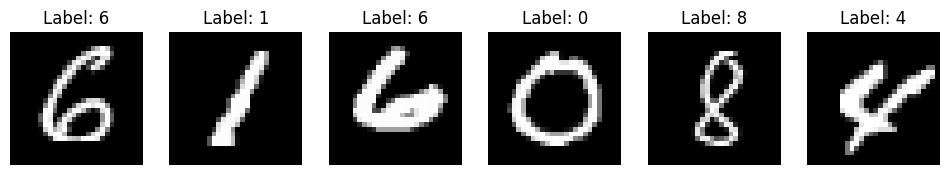

In [6]:
import matplotlib.pyplot as plt

import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = labels[i].item()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

Przykładowe obrazki w zbiorze.

In [7]:
# define model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

W tej sieci użyto podstawowych operacji, takich jak Conv2d, które wykonfuje operacje konwolucji i moze aplikowac kilka roznych filtrow, tym samym tworząc rózne `feature map`, gdzie każdy filtr może pełnić różne role (znajdowac krawedzie, albo wyostrac, etc). Kazdy element w feature map jest poddawany funkcji relu, ktora usuwa negatywne wartosci. Operacja MaxPool2d naklada 'kernel' ktory wyciaga najwieksa wartosc, tym samym zmniejszac rozmiay. Warstwa Linear jest typowa warstwą neuronów, gdzie mamy połączone ze sobą neurony w warstwie wejściowej i wyjściowej. Sieć jest zbudowana tak, by na koniec mieć tyle wyjść ile klas.

In [8]:
# train model

import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score, f1_score

epochs = 10
print_every_n_batches = 50

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# metrics to calcuate
accuracies = []
losses = []
precisions = []
f1s = []


for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0
        running_precision = 0.0
        running_f1 = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            pred_labels = outputs.argmax(dim=1).cpu().detach().numpy()
            true_labels = labels.cpu().detach().numpy()

            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()
            
            running_precision += precision_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))
            running_f1 += f1_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                precisions.append(running_precision / print_every_n_batches)
                f1s.append(running_f1 / print_every_n_batches)

                running_accuracy = running_loss = running_precision = running_f1 = 0.0

[1,    50] loss: 1.531, accuracy: 0.548
[1,   100] loss: 0.470, accuracy: 0.848
[1,   150] loss: 0.320, accuracy: 0.900
[1,   200] loss: 0.241, accuracy: 0.929
[1,   250] loss: 0.202, accuracy: 0.939
[1,   300] loss: 0.150, accuracy: 0.953
[1,   350] loss: 0.143, accuracy: 0.955
[1,   400] loss: 0.138, accuracy: 0.958
[1,   450] loss: 0.122, accuracy: 0.965
[2,    50] loss: 0.103, accuracy: 0.969
[2,   100] loss: 0.096, accuracy: 0.969
[2,   150] loss: 0.095, accuracy: 0.973
[2,   200] loss: 0.076, accuracy: 0.976
[2,   250] loss: 0.087, accuracy: 0.974
[2,   300] loss: 0.081, accuracy: 0.973
[2,   350] loss: 0.082, accuracy: 0.974
[2,   400] loss: 0.076, accuracy: 0.976
[2,   450] loss: 0.087, accuracy: 0.974
[3,    50] loss: 0.062, accuracy: 0.980
[3,   100] loss: 0.067, accuracy: 0.978
[3,   150] loss: 0.066, accuracy: 0.979
[3,   200] loss: 0.067, accuracy: 0.979
[3,   250] loss: 0.060, accuracy: 0.982
[3,   300] loss: 0.060, accuracy: 0.983
[3,   350] loss: 0.052, accuracy: 0.983


W tym kroku uczymy model, pobieramy obrazki z jednego batchu, przepuszczamy przez siec, obliczamy stratę, liczymy gradient i potem optymalizujemy m.i. wagi za pomaca optimizatora Adam (mozna uzyc prostrzego SGD, ale tu uzyty optimizer z adaptywanym learning rate).

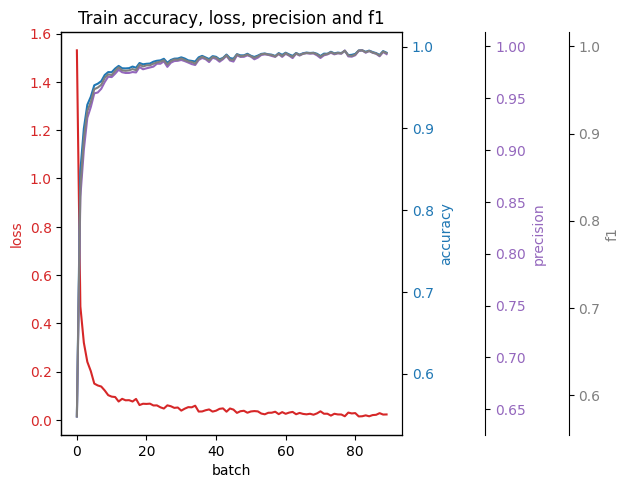

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color = 'tab:purple'
ax3.set_ylabel('precision', color=color)
ax3.plot(precisions, color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
color = 'tab:gray'
ax4.set_ylabel('f1', color=color)
ax4.plot(f1s, color=color)
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Train accuracy, loss, precision and f1')
plt.show()

W tym kroku pokazujemy jak spadała funkcja strat, gdyby ona rosła od pewnego momentu, to mozna by było mówić o przeuczeniu modelu (kiedy model sie zbyt dopasowuje do danych uczacych). Też gdyby na wykresie się znalazł train accuracy, to można było mówić o miarze przeuczenia. O niedouczeniu mozemy mowic wtedy, kiedy model nie jest w stanie generalizowac problem na akceptowalnym poziomie. 

W przypadku tego wykresu, w poprzednich uruchomieniach, jak i na wykresie loss dla modeli ponizej pojawialy sie 'zębatki' na wykresie. Mozna probowac ich sie pozbyc zmieniajac batch size oraz learning rate. Zbyt maly batch size w stosunku do learning rate daje to, ze w kazdej iteracji wyniki iteracji bardzo mocno wplywaja na wynik, czyli mala czesc zbioru mocno wplywa na calosciawa wizje tego zbioru, wiec wynik oscyluje okolo optimium objawiajac sie zebatkowym wykresem strat. Dlatego mozna albo zwiekszyc batch size albo zmniejszyc learning rate. Dlatego batch size w tym przypadku zwiekszono do 124.

Na wykresie tez jest pokazane accuracy, precision and f1. Są to rózne metriki oparte o rodzaje klasyfikacji outputu modela: TP, TN, FP, FN. Kazdy z przedstawionych w idealnym przypadku wynosilby 1, wiec wynik jest pozytywny.

In [10]:
import pandas as pd
from torchmetrics import classification as metrics

accuracy = metrics.MulticlassAccuracy(num_classes=10, average=None).cuda()
precision = metrics.MulticlassPrecision(num_classes=10, average=None).cuda()
recall = metrics.MulticlassRecall(num_classes=10, average=None).cuda()

stats = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])


with torch.no_grad():

    for i in range(5):
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)

        
        stats_data = {'Accuracy': [accuracy.compute().cpu().numpy()],
              'Precision': [precision.compute().cpu().numpy()],
              'Recall': [recall.compute().cpu().numpy()]}

        stats = pd.concat([stats, pd.DataFrame(stats_data)], ignore_index=True)

        accuracy.reset()
        precision.reset()
        recall.reset()

# average across classes
stats.applymap(lambda x: np.mean(x)).style


,Accuracy,Precision,Recall
0,0.988572,0.988827,0.988572
1,0.988572,0.988827,0.988572
2,0.988572,0.988827,0.988572
3,0.988572,0.988827,0.988572
4,0.988572,0.988827,0.988572


W tym kroku testujemy model i widzimy wyniki na piziomie 98%, co zdaniem autora jest pozytywnym wynikiem. Model sie otrzymal deterministyczny, natomiast gdyby do transorm test dodac vertical flip, to stal by sie niedeterministyczny i wynik mocno by spadł.

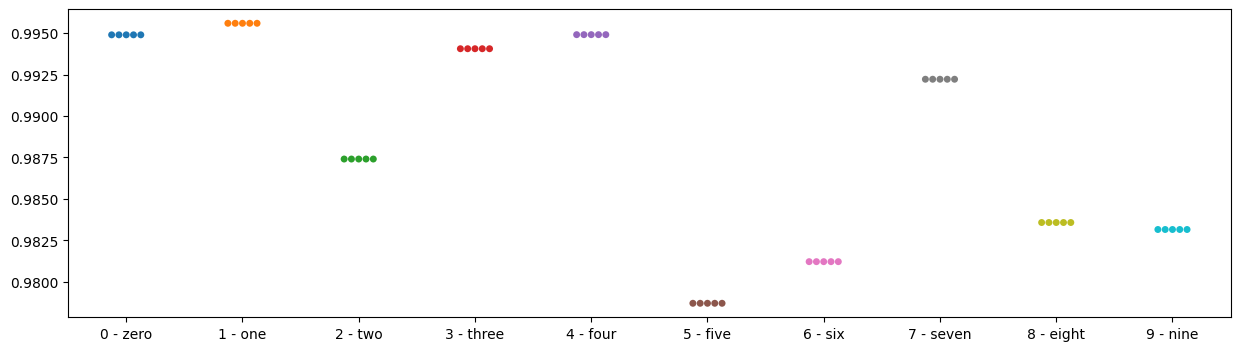

In [11]:
import seaborn as sns

df_mc = pd.DataFrame()

for i, label in enumerate(testset.classes):
    df_mc[label] = stats['Accuracy'].apply(lambda x: x[i])

sns.swarmplot(data=df_mc)
plt.gcf().set_size_inches(15, 4)
plt.show()


Na wykresie powyzej pokazane accuracy dla poszegolnych klas.

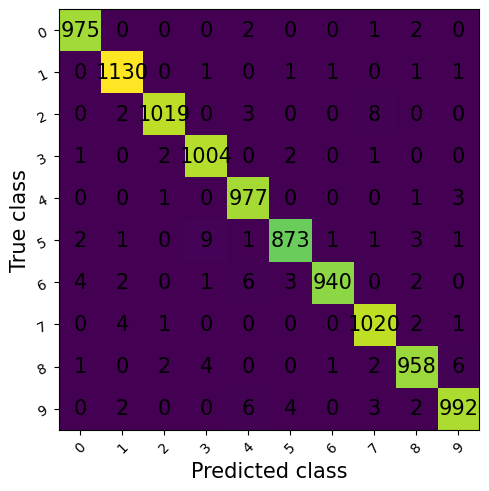

In [12]:
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix


confusion_matrix = MulticlassConfusionMatrix(num_classes=10).cuda()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        confusion_matrix(predicted, labels)

fig_, ax_ = confusion_matrix.plot()
plt.show()

W tym kroku pokazana confusion jest konfusion matrix. Pokazuje ona ilosc poprawnie zakwalifikowanych jak i niepoprawnie. Czy w naszym przypadku 940 szostek zostalo poprawnie zakwalifikowane, natomiast 4 szostki zostały błednie zawalifikowane do 0.

Dla pozostałych modeli podejście było bardzo podobne, dlatego komentarze juz będą dotyczyli jakichś specyficznych momentów.

### Fashion mnist

In [13]:
# download fashion mnist

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 26421880/26421880 [00:10<00:00, 2589528.80it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270371.25it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5111190.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13858971.11it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



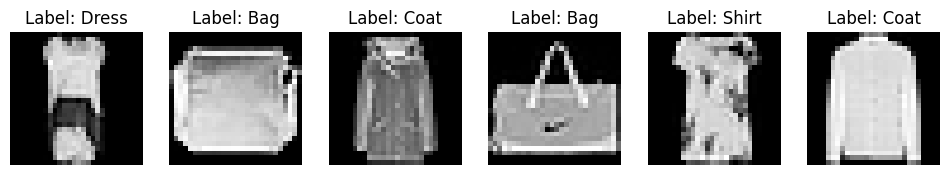

In [14]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = trainset.classes[labels[i].item()]
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

# Show the plot
plt.show()

Fashion mnist przedstawia 10 mozliwych elementow garderoby.

In [15]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Define max pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # 7x7 image dimension after two max-pooling layers
        self.fc2 = nn.Linear(256, 10)  # Output 10 classes for Fashion MNIST

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Reshape the tensor for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [16]:
# train model

import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score, f1_score

epochs = 10
print_every_n_batches = 50

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# metrics to calcuate
accuracies = []
losses = []
precisions = []
f1s = []


for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0
        running_precision = 0.0
        running_f1 = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            pred_labels = outputs.argmax(dim=1).cpu().detach().numpy()
            true_labels = labels.cpu().detach().numpy()

            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()
            
            running_precision += precision_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))
            running_f1 += f1_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                precisions.append(running_precision / print_every_n_batches)
                f1s.append(running_f1 / print_every_n_batches)

                running_accuracy = running_loss = running_precision = running_f1 = 0.0

[1,    50] loss: 1.041, accuracy: 0.632
[1,   100] loss: 0.621, accuracy: 0.779
[1,   150] loss: 0.554, accuracy: 0.799
[1,   200] loss: 0.505, accuracy: 0.824
[1,   250] loss: 0.492, accuracy: 0.820
[1,   300] loss: 0.451, accuracy: 0.834
[1,   350] loss: 0.417, accuracy: 0.846
[1,   400] loss: 0.409, accuracy: 0.854
[1,   450] loss: 0.408, accuracy: 0.849
[1,   500] loss: 0.387, accuracy: 0.861
[1,   550] loss: 0.361, accuracy: 0.866
[1,   600] loss: 0.358, accuracy: 0.867
[1,   650] loss: 0.340, accuracy: 0.883


[1,   700] loss: 0.334, accuracy: 0.879
[1,   750] loss: 0.353, accuracy: 0.870
[1,   800] loss: 0.354, accuracy: 0.870
[1,   850] loss: 0.338, accuracy: 0.876
[1,   900] loss: 0.324, accuracy: 0.882
[2,    50] loss: 0.314, accuracy: 0.886
[2,   100] loss: 0.319, accuracy: 0.884
[2,   150] loss: 0.300, accuracy: 0.891
[2,   200] loss: 0.317, accuracy: 0.882
[2,   250] loss: 0.305, accuracy: 0.890
[2,   300] loss: 0.291, accuracy: 0.891
[2,   350] loss: 0.300, accuracy: 0.886
[2,   400] loss: 0.298, accuracy: 0.893
[2,   450] loss: 0.297, accuracy: 0.892
[2,   500] loss: 0.281, accuracy: 0.897
[2,   550] loss: 0.314, accuracy: 0.888
[2,   600] loss: 0.269, accuracy: 0.904
[2,   650] loss: 0.286, accuracy: 0.894
[2,   700] loss: 0.273, accuracy: 0.898
[2,   750] loss: 0.258, accuracy: 0.905
[2,   800] loss: 0.257, accuracy: 0.906
[2,   850] loss: 0.272, accuracy: 0.894
[2,   900] loss: 0.279, accuracy: 0.892
[3,    50] loss: 0.268, accuracy: 0.900
[3,   100] loss: 0.266, accuracy: 0.903


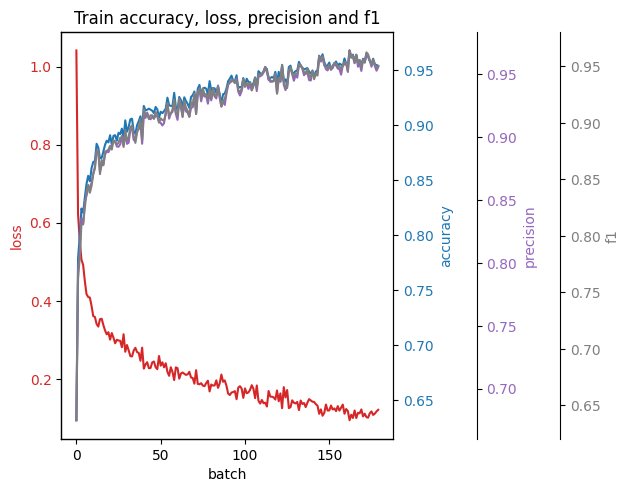

In [17]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color = 'tab:purple'
ax3.set_ylabel('precision', color=color)
ax3.plot(precisions, color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
color = 'tab:gray'
ax4.set_ylabel('f1', color=color)
ax4.plot(f1s, color=color)
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Train accuracy, loss, precision and f1')
plt.show()

Jak wspomniane wyżej widzimy zaburzenia na wykresie strat, z jednej strony punkty sa zbierane stosunkowow czesto, co 50 batchi, co tez moze sie przekladac na ksztalt, ale tez warto by bylo poekspperymentowac z batch size oraz learning rate.

In [18]:
import pandas as pd
from torchmetrics import classification as metrics

accuracy = metrics.MulticlassAccuracy(num_classes=len(testset.classes), average=None).cuda()
precision = metrics.MulticlassPrecision(num_classes=len(testset.classes), average=None).cuda()
recall = metrics.MulticlassRecall(num_classes=len(testset.classes), average=None).cuda()

stats = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])


with torch.no_grad():

    for i in range(5):
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)

        stats_data = {'Accuracy': [accuracy.compute().cpu().numpy()],
              'Precision': [precision.compute().cpu().numpy()],
              'Recall': [recall.compute().cpu().numpy()]}

        stats = pd.concat([stats, pd.DataFrame(stats_data)], ignore_index=True)

        accuracy.reset()
        precision.reset()
        recall.reset()

# average across classes
stats.applymap(lambda x: np.mean(x)).style


,Accuracy,Precision,Recall
0,0.924200,0.924974,0.924200
1,0.924200,0.924974,0.924200
2,0.924200,0.924974,0.924200
3,0.924200,0.924974,0.924200
4,0.924200,0.924974,0.924200


Wyniki w tym przypadku wyszły na poziomie 92%, co jest niezłym wynikiem, ale można próbować osiągnąć i lepsze wyniki.

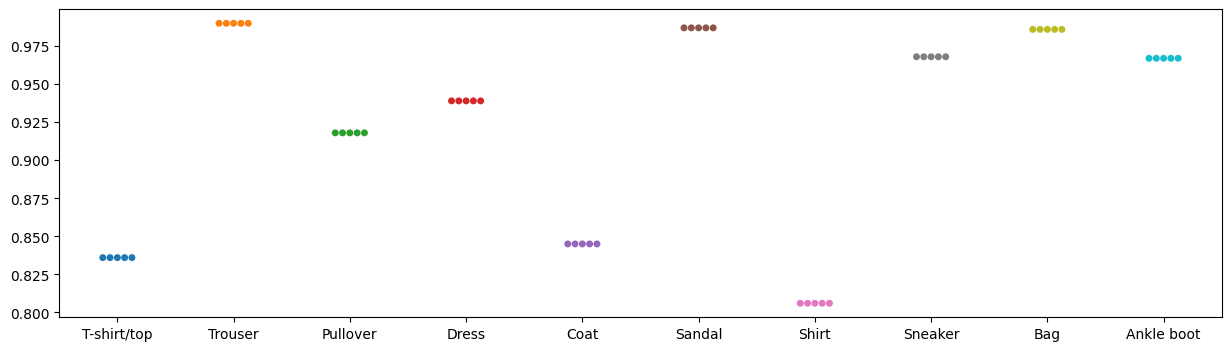

In [19]:
import seaborn as sns

df_mc = pd.DataFrame()

for i, label in enumerate(testset.classes):
    df_mc[label] = stats['Accuracy'].apply(lambda x: x[i])

sns.swarmplot(data=df_mc)
plt.gcf().set_size_inches(15, 4)
plt.show()


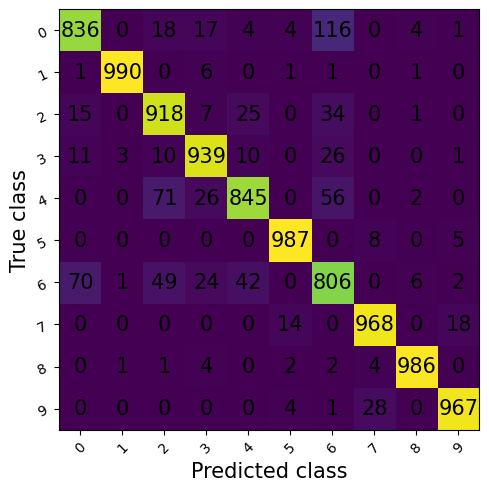

In [20]:
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix


confusion_matrix = MulticlassConfusionMatrix(num_classes=10).cuda()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        confusion_matrix(predicted, labels)

fig_, ax_ = confusion_matrix.plot()
plt.show()

### CIFAR-100

In [21]:
# download cifar100

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 169001437/169001437 [00:02<00:00, 66632174.77it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


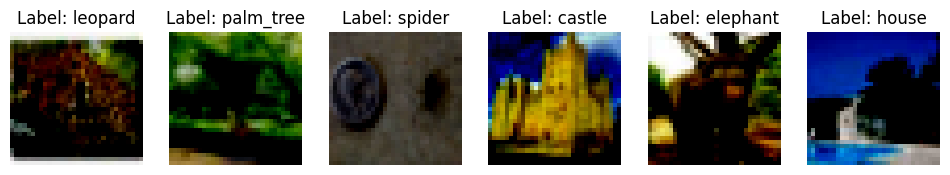

In [22]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = trainset.classes[labels[i].item()]

    axes[i].imshow(image.transpose(1, 2, 0))
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
    

# Show the plot
plt.show()

CIFAR 100 posiada obrazki kolorowe o znacznie gorzej jakosci niz MNIST o rozmiarze 32x32, oraz 100 klas.

In [23]:
# define fancy model for cifar100

import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # Define max pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        # Define fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # 4x4 image dimension after two max-pooling layers
        self.fc2 = nn.Linear(256, 100)  # Output 100 classes for CIFAR100

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Reshape the tensor for fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

W tym kroku jest stosunkowo prosty model, ktory i tak sie nieźle zachowuje, jak zobaczymy później.

In [24]:
# train model
from sklearn.metrics import precision_score, recall_score, f1_score

epochs = 10
print_every_n_batches = 50

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# metrics to calcuate
accuracies = []
losses = []
precisions = []
f1s = []


for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0
        running_precision = 0.0
        running_f1 = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            pred_labels = outputs.argmax(dim=1).cpu().detach().numpy()
            true_labels = labels.cpu().detach().numpy()

            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()
            
            running_precision += precision_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))
            running_f1 += f1_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                precisions.append(running_precision / print_every_n_batches)
                f1s.append(running_f1 / print_every_n_batches)

                running_accuracy = running_loss = running_precision = running_f1 = 0.0

[1,    50] loss: 4.527, accuracy: 0.020
[1,   100] loss: 4.241, accuracy: 0.053
[1,   150] loss: 4.117, accuracy: 0.064
[1,   200] loss: 3.970, accuracy: 0.080
[1,   250] loss: 3.905, accuracy: 0.098
[1,   300] loss: 3.837, accuracy: 0.105
[1,   350] loss: 3.744, accuracy: 0.125
[1,   400] loss: 3.669, accuracy: 0.129
[1,   450] loss: 3.604, accuracy: 0.156
[1,   500] loss: 3.547, accuracy: 0.155
[1,   550] loss: 3.473, accuracy: 0.161
[1,   600] loss: 3.389, accuracy: 0.187
[1,   650] loss: 3.367, accuracy: 0.193
[1,   700] loss: 3.313, accuracy: 0.197
[1,   750] loss: 3.233, accuracy: 0.214
[2,    50] loss: 3.127, accuracy: 0.225
[2,   100] loss: 3.084, accuracy: 0.242
[2,   150] loss: 3.045, accuracy: 0.257
[2,   200] loss: 3.027, accuracy: 0.244
[2,   250] loss: 2.980, accuracy: 0.259


[2,   300] loss: 2.995, accuracy: 0.260
[2,   350] loss: 2.988, accuracy: 0.263
[2,   400] loss: 2.906, accuracy: 0.267
[2,   450] loss: 2.928, accuracy: 0.270
[2,   500] loss: 2.872, accuracy: 0.285
[2,   550] loss: 2.824, accuracy: 0.289
[2,   600] loss: 2.810, accuracy: 0.292
[2,   650] loss: 2.803, accuracy: 0.310
[2,   700] loss: 2.762, accuracy: 0.297
[2,   750] loss: 2.760, accuracy: 0.307
[3,    50] loss: 2.703, accuracy: 0.318
[3,   100] loss: 2.643, accuracy: 0.318
[3,   150] loss: 2.630, accuracy: 0.333
[3,   200] loss: 2.628, accuracy: 0.335
[3,   250] loss: 2.596, accuracy: 0.339
[3,   300] loss: 2.530, accuracy: 0.340
[3,   350] loss: 2.546, accuracy: 0.348
[3,   400] loss: 2.527, accuracy: 0.345
[3,   450] loss: 2.545, accuracy: 0.360
[3,   500] loss: 2.520, accuracy: 0.353
[3,   550] loss: 2.549, accuracy: 0.341
[3,   600] loss: 2.493, accuracy: 0.362
[3,   650] loss: 2.453, accuracy: 0.369
[3,   700] loss: 2.520, accuracy: 0.348
[3,   750] loss: 2.463, accuracy: 0.371


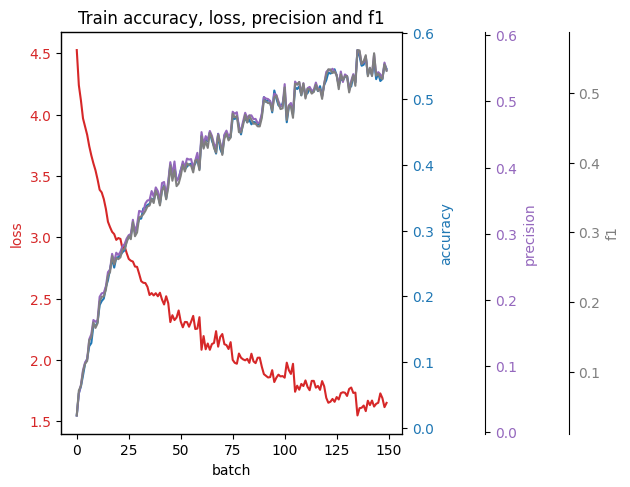

In [25]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color = 'tab:purple'
ax3.set_ylabel('precision', color=color)
ax3.plot(precisions, color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
color = 'tab:gray'
ax4.set_ylabel('f1', color=color)
ax4.plot(f1s, color=color)
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Train accuracy, loss, precision and f1')
plt.show()


Wykres strat bardzo podobny, do tych na górze, ale uczenie się odbywa o wiele wolniej i z punktu widzenia autora wykres wskazuje, ze co najmniej mozna zwiekszyc ilosc epok, ze wzgledu na to, ze wykres sie nie wyplaszcza.

In [26]:
import pandas as pd
from torchmetrics import classification as metrics

accuracy = metrics.MulticlassAccuracy(num_classes=len(testset.classes), average=None).cuda()
precision = metrics.MulticlassPrecision(num_classes=len(testset.classes), average=None).cuda()
recall = metrics.MulticlassRecall(num_classes=len(testset.classes), average=None).cuda()

stats = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])


with torch.no_grad():
    for i in range(5):
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)

        stats_data = {'Accuracy': [accuracy.compute().cpu().numpy()],
              'Precision': [precision.compute().cpu().numpy()],
              'Recall': [recall.compute().cpu().numpy()]}

        stats = pd.concat([stats, pd.DataFrame(stats_data)], ignore_index=True)

        accuracy.reset()
        precision.reset()
        recall.reset()

# average across classes
stats.applymap(lambda x: np.mean(x)).style

,Accuracy,Precision,Recall
0,0.468200,0.479423,0.468200
1,0.468200,0.479423,0.468200
2,0.468200,0.479423,0.468200
3,0.468200,0.479423,0.468200
4,0.468200,0.479423,0.468200


Wyniki są na poziomie 46-47%, nie jest to najlepszy wynik, ale też nie jest przypadkowy, bo szansa przypadkowo przyporzadkowac poprawna klase do jednego obrazka wynosi 1%, wieć moglibyśmy wyciągnąć jakis uzytek z tego modelu, natomiast zostaje tu duzo pracy.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


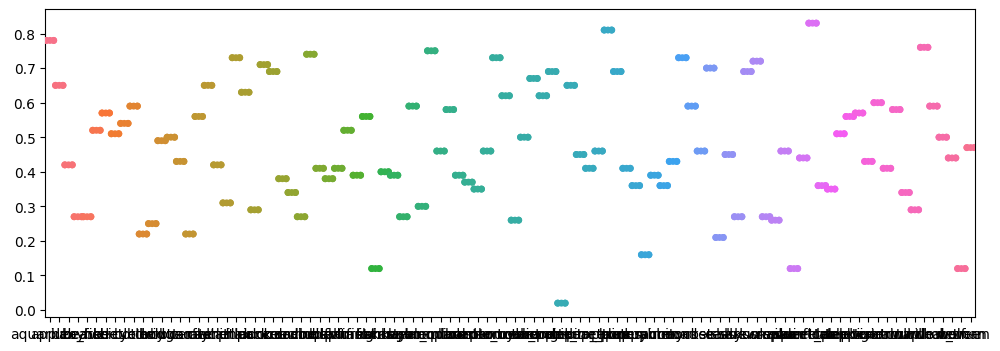

In [29]:
import seaborn as sns

df_mc = pd.DataFrame()

for i, label in enumerate(testset.classes):
    df_mc[label] = stats['Accuracy'].apply(lambda x: x[i])

sns.swarmplot(data=df_mc)
plt.gcf().set_size_inches(12, 4)
plt.show()


In [30]:
from torchmetrics.classification import MulticlassConfusionMatrix


confusion_matrix = MulticlassConfusionMatrix(num_classes=100).cuda()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        confusion_matrix(predicted, labels)

fig = plt.figure(figsize=(100, 100))
confusion_matrix.plot(ax=fig.gca())
ax = fig.gca()
ax.set_yticklabels([testset.classes[i] for i in range(100)])
ax.set_xticklabels([testset.classes[i] for i in range(100)])
plt.show()

Interesujaca rzecza na tej feature map jest to, ze jeden element zostal w pelni niepoprawnie zakwalifikowany, gdzie poprawne zakwalifikowanie odbylo sie tylko 2 razy.

In [32]:
%pip install torchview

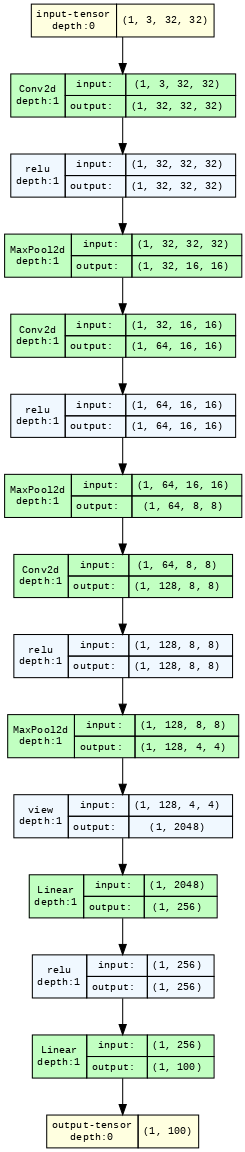

In [38]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

model_graph = draw_graph(Net(), input_size=(1,3,32, 32), expand_nested=True)

model_graph.visual_graph

A w tym kroku, chciałem przedstawić możliwości do wizualizacji sieci.